In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

 Web Scraping

In [4]:
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 10  # Set this to the total number of pages you want to scrape
page_size = 100
reviews = []

for i in range(1, pages + 1):
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize=100"
    response = requests.get(url)
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    
    for para in parsed_content.find_all("div", {"class": "text_content"}):
        reviews.append(para.get_text())

print(f"Total Reviews Collected: {len(reviews)}")


Total Reviews Collected: 1000


In [5]:
df = pd.DataFrame()
df["reviews"] = reviews
df.head()

,reviews
0,✅ Trip Verified | We have sat on this plane fo...
1,Not Verified | British Airways stranding my w...
2,✅ Trip Verified | Although like many these d...
3,✅ Trip Verified | This flight was British Airw...
4,Not Verified | The worst airline I have ever f...


In [6]:
#Copying scraped data in a csv file
df.to_csv("BA_customer_reviews.csv")

In [7]:
# Cleaning Data
def clean_text(review):   
    review = review.replace("✅ Trip Verified |", "").replace("Not Verified |", "").strip()
    review = re.sub(r"[^a-zA-Z\s]", "", review)  # Remove special characters and numbers
    review = review.lower()  # Convert to lowercase
    return review

 
cleaned_reviews = [clean_text(review) for review in reviews]

 
print(f"Cleaned {len(cleaned_reviews)} reviews:")
for i, review in enumerate(cleaned_reviews[:5], 1):  # Display the first 5 cleaned reviews
    print(f"{i}: {review}")



Cleaned 1000 reviews:
1: we have sat on this plane for an hour and forty five minutes awaiting takeoff due to bad weather in london this is understandable for safety fortunately i have a long layover so this delay does not affect me however many others are not so lucky while waiting we were given one small bottle of water and one tiny pack of corn kernels later food and drink were offered for purchase this is my complaint after sitting idle on this plane for nearly two hours and possibly missing connecting flights they cant give us a free bag of chips and a coke when i asked i was told no is british airways really this cheap and money grubbing
2: british airways stranding my wife and i at heathrow airport for  days with no access to our baggage we we told by airline employees to purchase any necessities toiletries refreshments etc and wed be reimbursed that claim was denied with ba claiming that weather was the reason for the delay an outright lie since every other airline in london wa

In [8]:
df = pd.read_csv("BA_reviews.csv")

# Remove null or empty reviews
df = df[df['reviews'].notna()]
df.isnull()

,Unnamed: 0,reviews
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False
...,...,...
995,False,False
996,False,False
997,False,False
998,False,False


Word Cloud

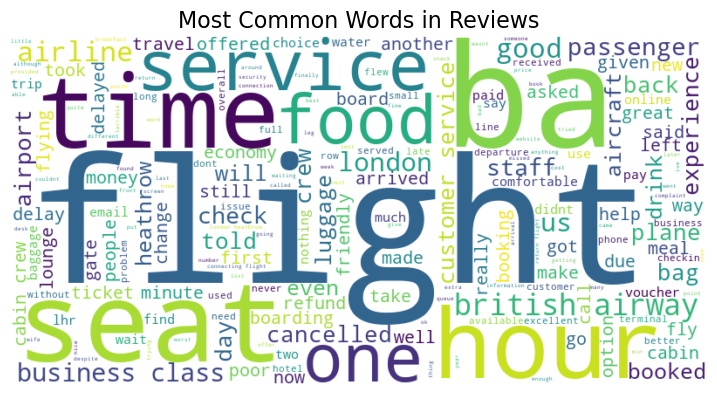

In [13]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud


df['cleaned_reviews'] = cleaned_reviews  
# Combine all the cleaned reviews into one large string for word cloud generation
text = " ".join(review for review in df['cleaned_reviews'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)

 
plt.figure(figsize=(9, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Common Words in Reviews", fontsize=16)
plt.show()

 Sentiment Analysis

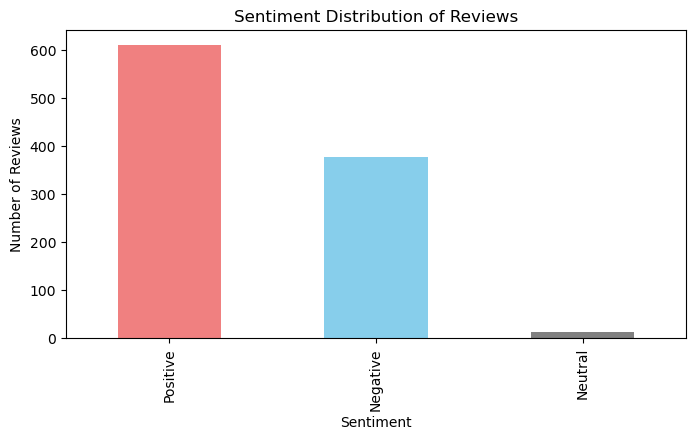

In [14]:
from textblob import TextBlob

# Sentiment Analysis
def get_sentiment(text):
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0:
        return "Positive"
    elif analysis.sentiment.polarity < 0:
        return "Negative"
    else:
        return "Neutral"

df['sentiment'] = df['cleaned_reviews'].apply(get_sentiment)

# Sentiment Distribution
df['sentiment'].value_counts().plot(kind='bar', color=['lightcoral', 'skyblue', 'gray'], figsize=(8, 4))
plt.title("Sentiment Distribution of Reviews")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.show()

Topic Modeling

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Vectorize the text data
# transforms the text into a document-term matrix.
vectorizer = CountVectorizer(stop_words="english", max_features=1000)
review_matrix = vectorizer.fit_transform(df['cleaned_reviews'])

# Perform LDA
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(review_matrix)

# Display top words for each topic
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx + 1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

display_topics(lda, vectorizer.get_feature_names_out(), 10)

Topic 1:
flight ba cancelled customer service booked british told airways refund
Topic 2:
flight british airways london airport hours luggage heathrow service delayed
Topic 3:
class business ba seat service seats flight economy british airlines
Topic 4:
flight good crew food ba time service cabin club lounge
Topic 5:
ba flight staff passengers hour plane check luggage late time


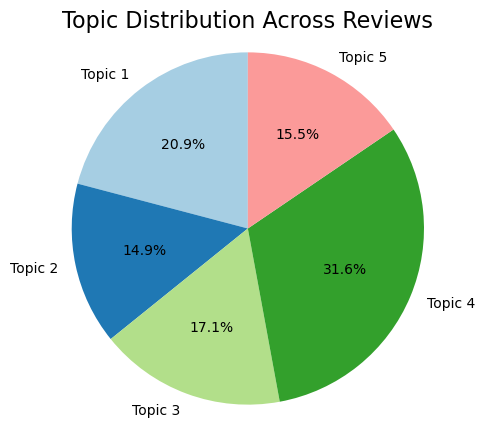

In [16]:

topic_proportions = lda.transform(review_matrix)

#Topic with highest proportion
dominant_topics = topic_proportions.argmax(axis=1)

# Counting the occurrences of each topic
topic_counts = np.bincount(dominant_topics)

# Labels for the topics
labels = [f'Topic {i+1}' for i in range(len(topic_counts))]

# Create the pie chart
plt.figure(figsize=(5, 5))
plt.pie(topic_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
plt.title('Topic Distribution Across Reviews', fontsize=16)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


Insights:
Top 5 Topics discussed in Reviews: 

Topic 1: Focuses on flight cancellations, customer service, and the refund process. Passengers have expressed frustration regarding booked flights being canceled and the difficulty in obtaining a refund from British Airways. 

Topic 2: Highlights flight delays, issues with luggage handling, and airport operations at Heathrow. Passengers mention long waiting times at the airport and the inconvenience caused by delays. 

Topic 3: Discusses seating in both business and economy class, with feedback on the comfort of seats and the quality of service provided by the airline during the flight. 

Topic 4: Centers around the in-flight experience, particularly the quality of food, the crew's behavior, and the overall service. Passengers discuss both positive and negative experiences with cabin services, including time spent in the lounge and overall service quality. 

Topic 5: Relates to flight durations, staff behavior, and airport procedures. Passengers comment on issues like delayed luggage, long check-in times, and the general timing of flights, as well as overall staff interactions.​​
 